# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# Configuration

In [3]:
path_lst = [
    '/content/drive/MyDrive/experiments/MNIST/SVM/',
    '/content/drive/MyDrive/experiments/IMDB/SVM/',
    '/content/drive/MyDrive/experiments/CIFAR10/SVM/'
]

# Load JSON Files

In [4]:
import json
def read_json(path):
  with open(path, 'r', encoding='utf-8') as file:
    data = json.load(file)
  return data

In [5]:
exp_id = '103'

In [6]:
import os

all_files = []
for folder in path_lst:
  files_inside_folder = os.listdir(folder)
  desired_files = [folder+item for item in files_inside_folder if item.startswith(exp_id)]
  all_files.extend(desired_files)

print(all_files)

['/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-0-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-20-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-40-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-60-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-80-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-influence-mnist(0-1)-100-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-label-flip-mnist(0-1)-20-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-label-flip-mnist(0-1)-40-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-label-flip-mnist(0-1)-60-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-label-flip-mnist(0-1)-80-modify.json', '/content/drive/MyDrive/experiments/MNIST/SVM/103-label-flip-mnist(0-1)-100-modify.json', '/content/drive/MyDrive/e

In [7]:
contents = [read_json(file_path) for file_path in all_files]

In [8]:
def extract_info(json_dict):
  attack = json_dict['log']['attack']
  train_acc = json_dict['log']['accuracy_Train']
  test_acc = json_dict['log']['accuracy_Test']
  ba = json_dict['log']['benign_accuracy'] if 'benign_accuracy' in json_dict['log'] else 0.0
  asr = json_dict['log']['attack_success_rate'] if 'attack_success_rate' in json_dict['log'] else 0.0
  poisoning_rate = json_dict['poisoning_rate']
  dataset = json_dict['log']['dataset']
  model = json_dict['log']['model']
  method = json_dict['log']['method']
  return {
      'attack':attack,
      'train_acc':train_acc,
      'test_acc':test_acc,
      'ba':ba,
      'asr':asr,
      'poisoning_rate':poisoning_rate,
      'dataset':dataset,
      'model':model,
      'method':method
  }

In [9]:
contents = [extract_info(item) for item in contents]

In [10]:
contents[10]

{'attack': 'label-flip',
 'train_acc': 100.0,
 'test_acc': 0.04728132387706856,
 'ba': 0.0,
 'asr': 1.0,
 'poisoning_rate': 1.0,
 'dataset': 'MNIST (0-1)',
 'model': 'SVM',
 'method': 'modify'}

# Make a Dataframe

In [11]:
import pandas as pd

In [12]:
df = pd.DataFrame(contents)
df.head()

,attack,train_acc,test_acc,ba,asr,poisoning_rate,dataset,model,method
0,influence,99.70,100.0,0.997000,0.0,0.0,MNIST (0-1),SVM,modify
1,influence,99.85,99.0,0.998125,1.0,0.2,MNIST (0-1),SVM,modify
2,influence,99.75,99.5,0.995833,1.0,0.4,MNIST (0-1),SVM,modify
3,influence,99.30,97.0,0.982500,1.0,0.6,MNIST (0-1),SVM,modify
4,influence,99.75,97.5,0.987500,1.0,0.8,MNIST (0-1),SVM,modify


In [13]:
df['dataset'].unique()

array(['MNIST (0-1)', 'IMDB', 'CIFAR10(0-6)'], dtype=object)

In [14]:
def extract_special(attack, dataset, model, method):
  return df.groupby(['attack']).get_group(attack).groupby(['model']).get_group(model).groupby(['dataset']).get_group(dataset).groupby(['method']).get_group(method)

In [15]:
extract_special('backdoor','MNIST (0-1)','SVM', 'modify')

,attack,train_acc,test_acc,ba,asr,poisoning_rate,dataset,model,method
12,backdoor,98.176076,99.621749,0.995460,0.926964,0.2,MNIST (0-1),SVM,modify
13,backdoor,99.147256,98.912530,0.987498,0.997434,0.4,MNIST (0-1),SVM,modify
14,backdoor,99.336755,98.817967,0.984208,0.999474,0.6,MNIST (0-1),SVM,modify
15,backdoor,99.178839,96.312057,0.958942,1.000000,0.8,MNIST (0-1),SVM,modify
16,backdoor,99.968417,0.141844,0.000000,0.999684,1.0,MNIST (0-1),SVM,modify
17,backdoor,99.842084,99.905437,0.998421,0.000000,0.0,MNIST (0-1),SVM,modify


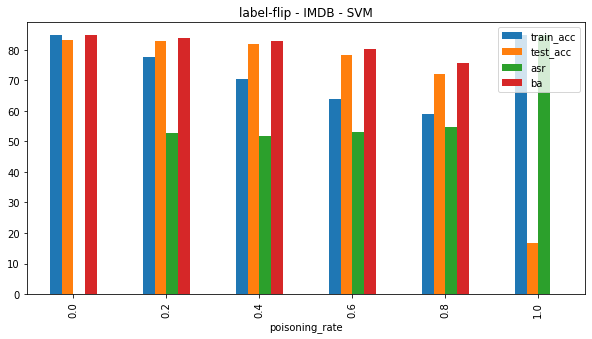

In [16]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10, 5]
attack = 'label-flip'
dataset = 'IMDB'
model = 'SVM'
method = 'modify'
tmp_df = extract_special(attack, dataset, model, method).sort_values('poisoning_rate')
tmp_df['asr'] = tmp_df['asr']*100
tmp_df['ba'] = tmp_df['ba']*100
title = ' - '.join((attack, dataset, model))
tmp_df.plot(kind='bar', x='poisoning_rate', y=['train_acc','test_acc','asr','ba'], title=title)
plt.savefig('/content/drive/MyDrive/experiments/Visualize/'+exp_id+'/'+title+'.jpg', dpi=300)

In [ ]:
tmp_df.sort_values('poisoning_rate')

,attack,train_acc,test_acc,ba,asr,poisoning_rate,dataset,model
32,backdoor,84.836,83.320,84.836000,0.000000,0.0,IMDB,SVM
29,backdoor,87.300,82.764,84.270000,99.420000,0.2,IMDB,SVM
28,backdoor,90.880,82.748,84.973333,99.740000,0.4,IMDB,SVM
27,backdoor,93.828,81.940,84.790000,99.853333,0.6,IMDB,SVM
26,backdoor,97.380,80.392,87.040000,99.965000,0.8,IMDB,SVM
36,backdoor,100.000,69.320,0.000000,100.000000,1.0,IMDB,SVM
